## Introduction:


This notebook is an implementation of an introsion detection in KDD dataset .. this is a classifiction problem (bad/ good intrusion) that suffers from imbalance classes where the distribtion of data in the training and testing sets are different (This makes the task more realistic) .. 

This is due to introducing new types of intrusions in the test set .. 

Dataset link ==> http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html


The raw training data was about four gigabytes of compressed binary TCP dump data from seven weeks of network traffic.  


The dataset consits of 42 variables and about 5 million records .. with connections labeled as either normal, or as an attack , with exactly one specific attack type.  Each connection record consists of about 100 bytes. 

Attacks fall into four main categories:

- DOS: denial-of-service, e.g. syn flood;
- R2L: unauthorized access from a remote machine, e.g. guessing password;
- U2R:  unauthorized access to local superuser (root) privileges, e.g., various ``buffer overflow'' attacks;
- probing: surveillance and other probing, e.g., port scanning.


Some people work on deriving features from the existing ones .. i.e. 

Stolfo et al.  defined higher-level features that help in distinguishing normal connections from attacks.  There are several categories of derived features. The ``same host'' features examine only the connections in the past two seconds that have the same destination host as the current connection, and calculate statistics related to protocol behavior, service, etc. The similar ``same service'' features examine only the connections in the past two seconds that have the same service as the current connection. "Same host" and "same service" features are together called  time-based traffic features of the connection records. 

Stolfo et al. used domain knowledge to add features that look for suspicious behavior in the data portions, such as the number of failed login attempts.  These features are called ``content'' features.


a tutorial for some deep learning solutions for this problem is here ==> 

https://www.analyticsvidhya.com/blog/2016/10/investigation-on-handling-structured-imbalanced-datasets-with-deep-learning/

In [23]:
## data manipulation
import numpy as np
import pandas as pd

## reading the data 
import json
import zipfile
import csv

## warnings
import warnings
warnings.filterwarnings("ignore")

## plotting .. 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [9]:
df = pd.read_csv('kddcup.data.gz')

In [5]:
df.head()

,0,tcp,http,SF,215,45076,0.1,0.2,0.3,0.4,...,0.17,0.00.6,0.00.7,0.00.8,0.00.9,0.00.10,0.00.11,0.00.12,0.00.13,normal.
0,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1,0,1.00,0,0,0,0,0,normal.
1,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1,0,0.50,0,0,0,0,0,normal.
2,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1,0,0.33,0,0,0,0,0,normal.
3,0,tcp,http,SF,239,486,0,0,0,0,...,4,1,0,0.25,0,0,0,0,0,normal.
4,0,tcp,http,SF,238,1282,0,0,0,0,...,5,1,0,0.20,0,0,0,0,0,normal.


In [6]:
np.shape(df)

(4898430, 42)

In [15]:
df['normal.'].unique()

array(['normal.', 'buffer_overflow.', 'loadmodule.', 'perl.', 'neptune.',
       'smurf.', 'guess_passwd.', 'pod.', 'teardrop.', 'portsweep.',
       'ipsweep.', 'land.', 'ftp_write.', 'back.', 'imap.', 'satan.',
       'phf.', 'nmap.', 'multihop.', 'warezmaster.', 'warezclient.',
       'spy.', 'rootkit.'], dtype=object)

In [17]:
np.shape(df['normal.'].unique())

(23,)

about 23 attack types .. 

mapping them to the 4 categories of attacks as follows:

    back dos
    buffer_overflow u2r
    ftp_write r2l
    guess_passwd r2l
    imap r2l
    ipsweep probe
    land dos
    loadmodule u2r
    multihop r2l
    neptune dos
    nmap probe
    perl u2r
    phf r2l
    pod dos
    portsweep probe
    rootkit u2r
    satan probe
    smurf dos
    spy r2l
    teardrop dos
    warezclient r2l
    warezmaster r2l


In [21]:
df.columns.to_series().groupby(df.dtypes).groups

{dtype('int64'): ['0',
  '215',
  '45076',
  '0.1',
  '0.2',
  '0.3',
  '0.4',
  '0.5',
  '1',
  '0.6',
  '0.7',
  '0.8',
  '0.9',
  '0.10',
  '0.11',
  '0.12',
  '0.13',
  '0.14',
  '0.15',
  '1.1',
  '1.2',
  '0.16',
  '0.17'],
 dtype('float64'): ['0.00',
  '0.00.1',
  '0.00.2',
  '0.00.3',
  '1.00',
  '0.00.4',
  '0.00.5',
  '0.00.6',
  '0.00.7',
  '0.00.8',
  '0.00.9',
  '0.00.10',
  '0.00.11',
  '0.00.12',
  '0.00.13'],
 dtype('O'): ['tcp', 'http', 'SF', 'normal.']}

## Comment:
the columns names are not meaningful .. however, the majority of them are numeric integers .. some of them are floats and 4 variables are categoical variables (including the dependent variable -attack type-)

In [33]:
df.isnull().any()

0          False
tcp        False
http       False
SF         False
215        False
45076      False
0.1        False
0.2        False
0.3        False
0.4        False
0.5        False
1          False
0.6        False
0.7        False
0.8        False
0.9        False
0.10       False
0.11       False
0.12       False
0.13       False
0.14       False
0.15       False
1.1        False
1.2        False
0.00       False
0.00.1     False
0.00.2     False
0.00.3     False
1.00       False
0.00.4     False
0.00.5     False
0.16       False
0.17       False
0.00.6     False
0.00.7     False
0.00.8     False
0.00.9     False
0.00.10    False
0.00.11    False
0.00.12    False
0.00.13    False
normal.    False
dtype: bool

None of the variables contain missing values ! :) 

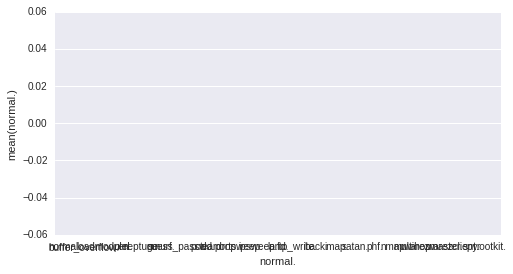

In [32]:
plt.figure(figsize=(8, 4))
sns.barplot(df['normal.'], df['normal.'].value_counts(), alpha = 0.8)  # I have to plot the distribution of each type 